In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
import os
from scipy.signal import find_peaks

In [58]:
# 사용자 변경
file_path = r"G:\다른 컴퓨터\KHU PC\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\최최종피규어들\csv파일\Energy\Voltage\Cut_A45H30D2.csv"

# 얼마나 앞뒤 비율 사용할 것인지 (%) ===
fraction_percent = 1  # 앞뒤 몇 %를 baseline 추정에 사용할지 조정 ####여기에서 오차 발생이 생길 수 있음.

# *ex) (10) = 10 μA/V 기준  %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 
Current_scale = 1

#내부저항 설정
R_load = 40*10e6 #ohm

mode = "voltage" # voltage or current

Offset: -1.715496
I_max: 0.000000 μA
I_min: -65.875000 μA
I_pp: 65.875000 μA


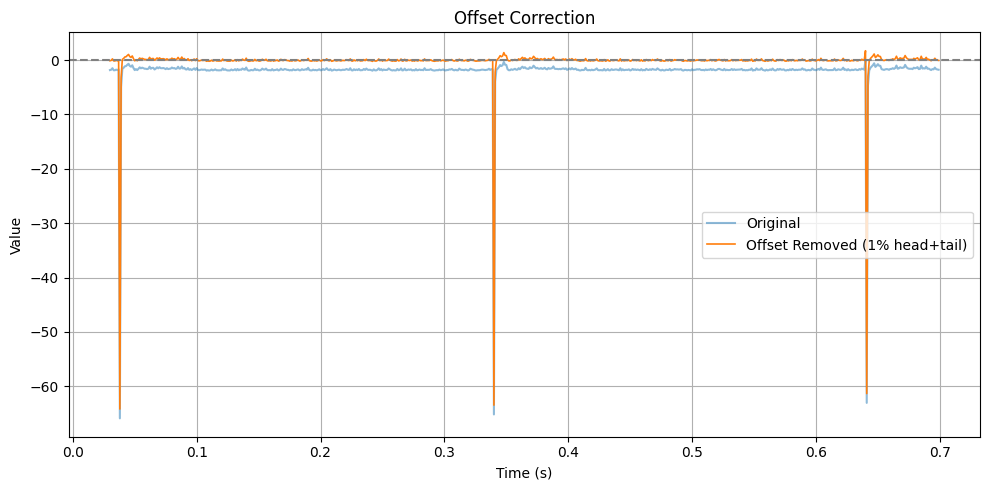

1 μA/V is considered


In [ ]:
df = pd.read_csv(file_path, header=None, skiprows=30)

df.columns = ['Time', 'Value']
# 데이터 형식 변환...글자 -> NaN
df["Time"] = pd.to_numeric(df["Time"], errors='coerce')
df["Value"] = pd.to_numeric(df["Value"], errors='coerce')

# === 전류 시계열 추출 ===
current = df['Value'].values
n_total = len(current)
n_fraction = int(n_total * (fraction_percent / 100))

# === 앞쪽과 뒤쪽 데이터로 baseline 계산 === ###여기서도 잘 조절해봐.
front_section = current[:n_fraction]
back_section = current[-n_fraction:]
baseline_offset = np.mean(np.concatenate([front_section, back_section]))
#baseline_offset = np.mean(np.concatenate([ back_section]))
baseline_offset = 0.0 if np.isnan(baseline_offset) else baseline_offset
print(f"Offset: {baseline_offset:4f}")

# === offset 제거 ===
Cor_value = current - baseline_offset
df['Cor_value'] = Cor_value


print(f"I_max: {df.iloc[:, 1].max(skipna=True):.6f} μA")
print(f"I_min: {df.iloc[:, 1].min(skipna=True):.6f} μA")
print(f"I_pp: {df.iloc[:, 1].max(skipna=True)-df.iloc[:, 1].min(skipna=True):.6f} μA")

# === 결과 시각화 ===
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Value'], label='Original', alpha=0.5)
plt.plot(df['Time'], df['Cor_value'], label=f'Offset Removed ({fraction_percent}% head+tail)', linewidth=1.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Offset Correction")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.ylim(-16,3)
plt.show()

df["Value"] = df["Cor_value"]*Current_scale
print(f"{Current_scale} μA/V is considered")

voltage mode is detected
 
Detected peaks at:
Time: 0.03800 s, Value: 0.000 μA
Time: 0.34000 s, Value: 0.000 μA
Time: 0.64100 s, Value: 0.000 μA


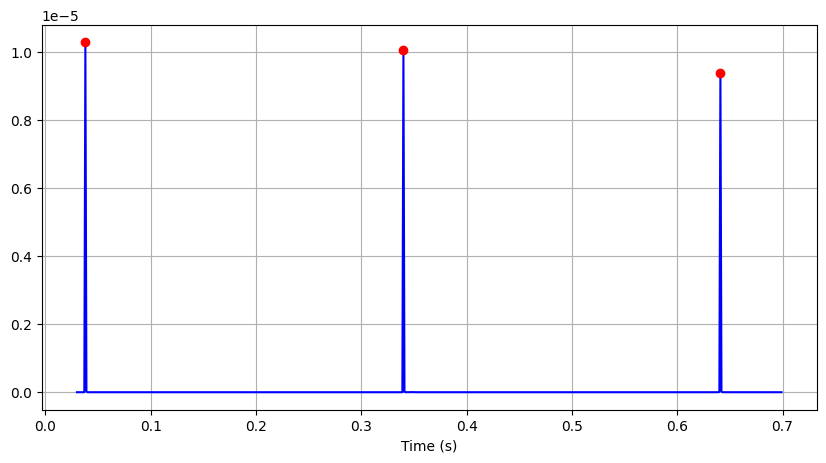

In [95]:
if 'Original_Value' not in df.columns:
    df['Original_Value'] = df['Value'].copy()

if mode == "voltage":
    #전압 기준
    df['Value'] = (df['Original_Value']**2)/R_load
    print("voltage mode is detected")
elif mode == "current":
    #전류 기준
    df['Value'] = (df['Original_Value']**2)*R_load
    print("current mode is detected")
    
else:
    print ("ERROR OCCURED. MODE SHOULD BE CHECKED.")

peaks, properties = find_peaks(df["Value"], height = 0.1*max(df['Value']), distance=10, prominence=0.1*max(df['Value']))  # Find peak & print time

print(" ")
print("Detected peaks at:")
for idx in peaks:
    print(f"Time: {df['Time'].iloc[idx]:.5f} s, Value: {df['Value'].iloc[idx]:.3f} μA")

plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:, 0], df.iloc[:, 1], label="AC current", color='b')
plt.plot(df["Time"].iloc[peaks], df["Value"].iloc[peaks], "ro", label='Detected Peaks')
plt.xlabel("Time (s)")
#plt.ylabel("Value (μA)")
#plt.title("Original current & peak")
#plt.ylim(-60,60)
plt.grid(True)
plt.show()



양수 전하 값: 0.000010 nC
음수 전하 값: 0.000000 nC


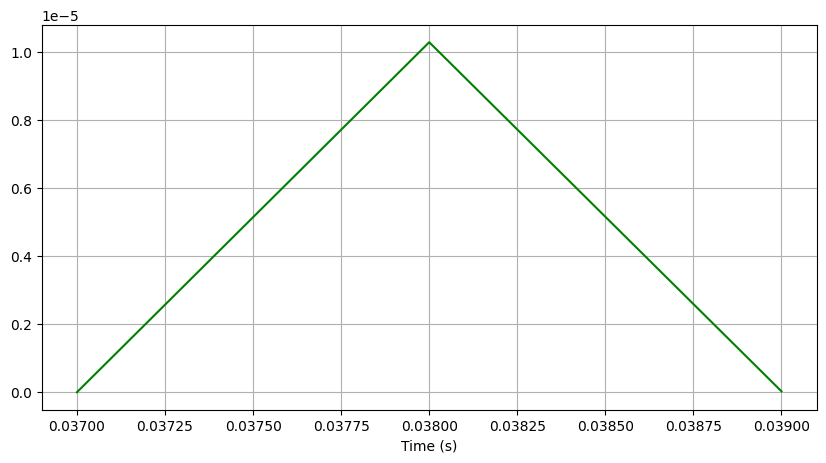

In [99]:
# 2. 특정 범위 선택
time_range = df["Time"]
time_range = ( 0.03600 , 0.03900 ) ########################## MUST BE MODIFIED MANUALLY

df_filtered = df[(df.iloc[:, 0] >= time_range[0]) & (df.iloc[:, 0] <= time_range[1])]

# 양수/음수 분리
p_value = df_filtered[df_filtered["Value"] > 0]
n_value = df_filtered[df_filtered["Value"] < 0]
p_time = p_value["Time"].values
p_current = p_value["Value"].values
n_time = n_value["Time"].values
n_current = n_value["Value"].values

# 전하 적분 함수 정의 (1개 포인트도 대응)
def segment_and_integrate(current, time, df_full, threshold=0.01, scale_factor=1e3):
    if len(time) < 1:
        return 0.0
    total_charge = 0.0
    group_start = 0
    time_diffs = np.diff(time)
    for i, dt in enumerate(time_diffs):
        if dt > threshold:
            segment_t = time[group_start:i+1]
            segment_i = current[group_start:i+1]
            if len(segment_t) > 1:
                total_charge += scale_factor * cumulative_trapezoid(segment_i, segment_t, initial=0)[-1]
            elif len(segment_t) == 1:
                dt_est = 1e-6
                t0 = segment_t[0]
                if t0 in df_full["Time"].values:
                    idx = df_full.index[df_full["Time"] == t0].tolist()[0]
                    if 0 < idx < len(df_full) - 1:
                        dt_est = (df_full.iloc[idx + 1]["Time"] - df_full.iloc[idx - 1]["Time"]) / 2
                total_charge += scale_factor * segment_i[0] * dt_est
            group_start = i + 1
    if group_start < len(time):
        segment_t = time[group_start:]
        segment_i = current[group_start:]
        if len(segment_t) > 1:
            total_charge += scale_factor * cumulative_trapezoid(segment_i, segment_t, initial=0)[-1]
        elif len(segment_t) == 1:
            dt_est = 1e-6
            t0 = segment_t[0]
            if t0 in df_full["Time"].values:
                idx = df_full.index[df_full["Time"] == t0].tolist()[0]
                if 0 < idx < len(df_full) - 1:
                    dt_est = (df_full.iloc[idx + 1]["Time"] - df_full.iloc[idx - 1]["Time"]) / 2
            total_charge += scale_factor * segment_i[0] * dt_est
    return total_charge

# 적분 수행
p_charge = segment_and_integrate(p_current, p_time, df)
n_charge = segment_and_integrate(n_current, n_time, df)

print(f"양수 전하 값: {p_charge:.6f} nC")
print(f"음수 전하 값: {n_charge:.6f} nC")

plt.figure(figsize=(10, 5))
plt.plot(df_filtered.iloc[:, 0], df_filtered.iloc[:, 1], label="Value", color='g')
plt.xlabel("Time (s)")
#plt.ylabel("Value (μA)") ### 단위 고려 중요
#plt.title("Flat DEG Value / d=2cm")
#plt.ylim(-45, 5)
#plt.legend()
plt.grid(True)
plt.show()

0.000


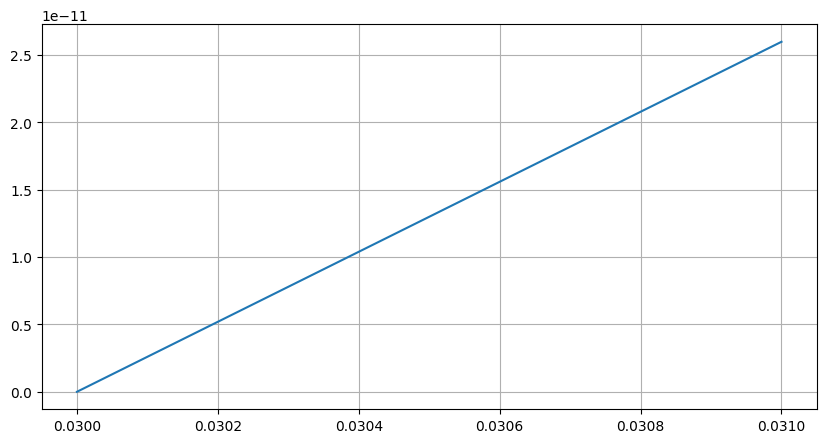

Filtered data saved at: G:\다른 컴퓨터\KHU PC\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\최최종피규어들\csv파일\Energy\Voltage\Charge_Cut_A45H30D2.csv


In [62]:
# ---- 아래 셀은 offset 바꿔가며 여러 번 실행해도 누적 안됨 ----
offset_value = 0.0########################## MUST BE MODIFIED MANUALLY

# 딱 한 번만 실행해서 '기준'을 저장
df_filtered_base = df_filtered.copy(deep=True)  # 원본 백업
current_adj = df_filtered_base["Value"] + offset_value

# 적분 (μA -> nC)
cumulative_charge = 1e3 * cumulative_trapezoid(current_adj.to_numpy(),
                                               df_filtered_base["Time"].to_numpy(),
                                               initial=0)

# 플롯
#print(f"{np.min(cumulative_charge):.3f} nC")
print(f"{np.min(cumulative_charge):.3f}")
plt.figure(figsize=(10, 5))
#plt.ylim(-0.37,0.02)
plt.plot(df_filtered_base["Time"], cumulative_charge, label="Cumulative Charge")
#plt.xlabel("Time (s)"); plt.ylabel("Collected Charge (nC)")
#plt.title("Flat DEG Charge / d=2cm");
plt.grid(True); plt.show()


# 8. 필터링된 데이터 저장
folder_path = os.path.dirname(file_path)
original_filename = os.path.basename(file_path)
filtered_file_name = f"Charge_{original_filename}"
filtered_file_path = os.path.join(folder_path, filtered_file_name)
#df_filtered.to_csv(filtered_file_path, index=False)

print(f"Filtered data saved at: {filtered_file_path}")
